In [6]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('order_items.csv','order_items'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/sathw/OneDrive/Documents/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value        

In [5]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db=mysql.connector.connect(host="localhost",username="root",password="1234",database="ecommerce")
cur=db.cursor()

In [21]:
 # List all unique cities where customers are located.
query="""select distinct customer_city from customers """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [22]:
 # Count the number of orders placed in 2017
query="""select  count(order_id) from  orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are ",data[0][0]

('total orders placed in 2017 are ', 225505)

In [23]:
# Find the total sales per category
query=""" select products.product_category category,round(sum(payments.payment_value),2)
sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on 
payments.order_id=order_items.order_id
group by category
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","sales"])
df


,category,sales
0,perfumery,24323455.67
1,Furniture Decoration,68648466.81
2,telephony,23370338.43
3,bed table bath,82202576.21
4,automotive,40910127.89
...,...,...
69,cds music dvds,57572.64
70,La Cuisine,139849.44
71,Fashion Children's Clothing,37712.16
72,PC Gamer,104372.64


In [24]:
# Calculate the percentage of orders that were paid in installments.
query=""" select sum(case when payment_installments>=1 then 1
else 0 end)/ count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data
"The percentage of orders that were paid in installments is",data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

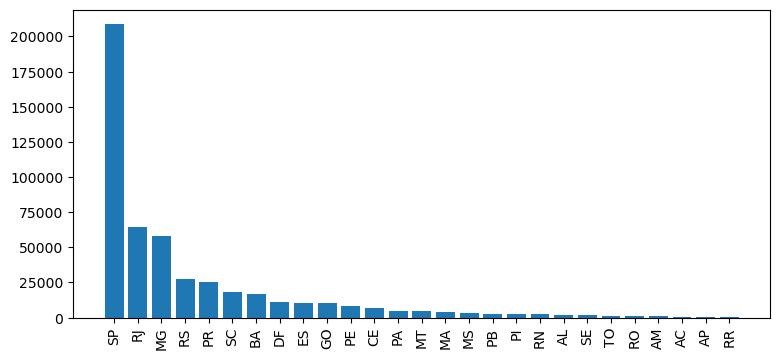

In [25]:
# Count the number of customers from each state.

query=""" select customer_state, count(customer_id) from customers 
group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])

df=df.sort_values(by="customer_count",ascending=False)
plt.figure(figsize=(9,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.show()

In [26]:
# Calculate the number of orders per month in 2018.
query="""select month(order_purchase_timestamp),count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by
month(order_purchase_timestamp)
"""
cur.execute(query)
data=cur.fetchall()
data
# df=pd.DataFrame(data,columns=["months","order_count"])
# o=["January","February","March","April","May","June","July","August","September","October","November","December"]
# ax=sns.barplot(x="months",y="order_count",data=df,order=o)
# plt.xticks(rotation=45)
# ax.bar_label(ax.containers[0])
# plt.show()

[(7, 31460),
 (8, 32560),
 (2, 33640),
 (6, 30835),
 (3, 36055),
 (1, 36345),
 (5, 34365),
 (4, 34695),
 (9, 80),
 (10, 20)]

In [27]:
# Find the average number of products per order, grouped by customer city.

query="""with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items 
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders 
from customers
join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer city","average orders"])
df.head(10)


,customer city,average orders
0,brotas de macaubas,20.00
1,tunapolis,20.00
2,capela do alto alegre,20.00
3,fortim,20.00
4,cairu,20.00
5,epitaciolandia,20.00
6,urucania,20.00
7,porto calvo,20.00
8,ipupiara,20.00
9,americo de campos,20.00


In [28]:
# Calculate the percentage of total revenue contributed by each product category.
query="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments)) *100,2) sales_percentage
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","percentage distribution"])
df.head(5)

,category,percentage distribution
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84


In [29]:
# Identify the correlation between product price and the number of times a product has been purchased.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector


db=mysql.connector.connect(host="localhost",username="root",password="1234",database="ecommerce")
cur=db.cursor()
query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","order_count","price"])
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef([arr1,arr2])
print("the correlation is",a[0][-1])


the correlation is -0.10631514167157563


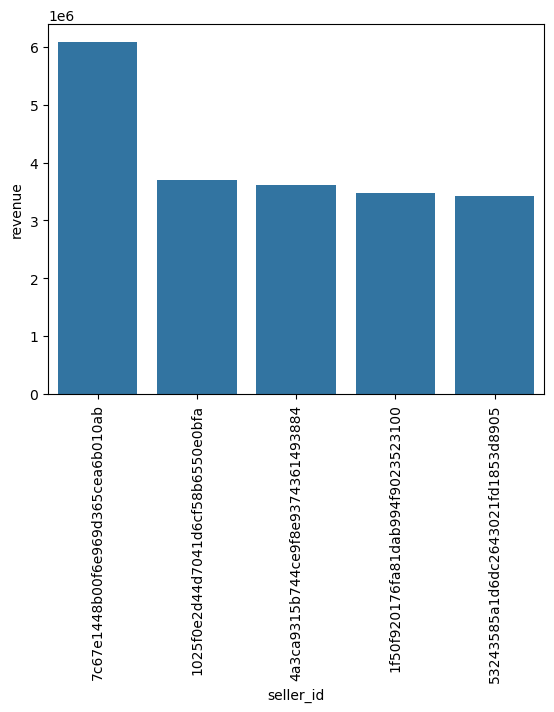

In [30]:
# Calculate the total revenue generated by each seller, and rank them by revenue.
query=""" select * , dense_rank() over(order by revenue desc) as rn
from (select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x="seller_id",y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()
            

In [31]:
# Calculate the moving average of order values for each customer over their order history.
query="""select customer_id,order_purchase_timestamp, payment,avg(payment)
over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id )as a"""
cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id", "order_purchase_timestamp", "payment", "mov_avg"])
df


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1558285,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1558286,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1558287,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1558288,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [35]:

# Calculate the cumulative sales per month for each year.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db=mysql.connector.connect(host="localhost",username="root",password="1234",database="ecommerce")
cur=db.cursor()
query="""select years,months,payment,sum(payment) 
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id
group by years,months order by years,months) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,3783.60,3.783600e+03
1,2016,10,886357.20,8.901408e+05
2,2016,12,294.30,8.904351e+05
3,2017,1,2077320.60,2.967756e+06
4,2017,2,4378620.14,7.346376e+06
5,2017,3,6747953.99,1.409433e+07
6,2017,4,6266820.44,2.036115e+07
7,2017,5,8893782.30,2.925493e+07
8,2017,6,7669145.70,3.692408e+07
9,2017,7,8885743.79,4.580982e+07


In [39]:
# Calculate the year-over-year growth rate of total sales.
query="""with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id= payments.order_id
group by years order by years)
select years,((payment-lag(payment,1) over(order by years))/payment-lag(payment,1)
 over(order by years))*100  from  a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["years","yoy % growth"])
df



,years,yoy % growth
0,2016,NaN
1,2017,-8.904341e+07
2,2018,-1.087462e+10
